## Summary

In this notebook, we test the accuracy of a network trained to reconstruct protein sequences on the *test dataset*, comprised of sequences of Gene3D domains excluded from the training dataset. We also evaluate the accuracy achieved by the network at predicting the ΔΔG of mutations, a task that this tangential to the objective that the network was trained to optimize.

----

## Imports

In [1]:
import tempfile
import time
import warnings
from collections import deque
from contextlib import contextmanager
from pathlib import Path

import numpy as np
import pandas as pd
import tqdm

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import proteinsolver
import proteinsolver.datasets
import pyarrow as pa
import pyarrow.parquet as pq
import torch
from kmbio import PDB
from matplotlib.ticker import FormatStrFormatter
from scipy import stats
from tensorflow.python.summary.summary_iterator import summary_iterator
from torch_geometric.data import DataLoader

/home/strokach/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/strokach/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/strokach/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/strokach/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: Futu

In [2]:
%matplotlib inline

try:
    inline_rc
except NameError:
    inline_rc = mpl.rcParams.copy()
    
mpl.rcParams.update({"font.size": 12})

## Parameters

In [3]:
UNIQUE_ID = "191f05de"  # No attention
# UNIQUE_ID = "0007604c"  # 5-layer graph-conv with attention, batch_size=1
# UNIQUE_ID = "91fc9ab9"  # 4-layer graph-conv with attention, batch_size=4

In [4]:
BEST_STATE_FILES = {
    #
    "191f05de": "protein_train/191f05de/e53-s1952148-d93703104.state"
}

In [5]:
DATA_ROOT = Path(tempfile.gettempdir())
DATA_ROOT = Path(tempfile.gettempdir()).joinpath("ml_data")
DATA_ROOT.mkdir(exist_ok=True)
DATA_ROOT

PosixPath('/tmp/strokach/ml_data')

In [6]:
NOTEBOOK_NAME = "protein_analysis"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME)
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('protein_analysis')

In [7]:
DATAPKG_DATA_DIR = Path(f"~/datapkg_data_dir").expanduser().resolve()
DATAPKG_DATA_DIR

PosixPath('/home/kimlab1/database_data/datapkg_output_dir')

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
proteinsolver.settings.data_url = DATAPKG_DATA_DIR.as_posix()
proteinsolver.settings.data_url

'/home/kimlab1/database_data/datapkg_output_dir'

## Load data

In [10]:
datasets = {}

In [11]:
DATAPKG_DATA_DIR.joinpath(
        "deep-protein-gen",
        "processed",
        "validation_data",
        "part-00000-4f535e50-cdf4-4275-b6b3-a3038f24a1a9-c000.snappy.parquet",
    ).is_file()

True

In [12]:
datasets["protein_valid"] = proteinsolver.datasets.ProteinInMemoryDataset(
    root=DATA_ROOT / "protein_valid",
    subset="valid",
    data_url=DATAPKG_DATA_DIR.joinpath(
        "deep-protein-gen",
        "processed",
        "validation_data",
        "part-00000-4f535e50-cdf4-4275-b6b3-a3038f24a1a9-c000.snappy.parquet",
    ).as_posix(),
)

In [13]:
datasets["protein_test"] = proteinsolver.datasets.ProteinInMemoryDataset(
    root=DATA_ROOT / "protein_test",
    subset="test",
    data_url=DATAPKG_DATA_DIR.joinpath(
        "deep-protein-gen",
        "processed",
        "validation_data",
        "part-00000-4f535e50-cdf4-4275-b6b3-a3038f24a1a9-c000.snappy.parquet",
    ).as_posix(),
)

### Protherm

In [14]:
file = DATAPKG_DATA_DIR.joinpath("deep-protein-gen/datasets-test/protherm/protherm.parquet").as_posix()

extra_columns = ["qseq", "residue_idx_1_corrected", "residue_idx_2_corrected", "distances"]
extra_column_renames = {
    "qseq": "sequence",
    "residue_idx_1_corrected": "row_index",
    "residue_idx_2_corrected": "col_index",
}
protherm_dataset = proteinsolver.datasets.ProteinInMemoryDataset(
    root=DATA_ROOT / "protherm",
    subset="",
    data_url=file,
    extra_columns=extra_columns,
    extra_column_renames=extra_column_renames,
)
protherm_df = pq.read_table(file).to_pandas()

In [15]:
protherm_dataset[0]

Data(Index=[1], edge_attr=[7356, 2], edge_index=[2, 7356], x=[162])

In [16]:
protherm_df.head(2)

,filename_wt,chain_id,mutation,cartesian_ddg_beta_nov15_cart_1,ddg_exp,cartesian_ddg_beta_nov16_cart_1,cartesian_ddg_score12_cart_1,cartesian_ddg_talaris2013_cart_1,cartesian_ddg_talaris2014_cart_1,ddg_monomer_soft_rep_design_1,local_filename_wt,structure_id,model_id,qseq,residue_idx_1_corrected,residue_idx_2_corrected,distances,mutation_matches_sequence,qseq_mutation
0,/home/kimlab2/database_data/biological-data-wa...,A,G44S,-1.808667,-0.53,-0.701,0.088,-0.289667,-0.633667,-2.384,/home/kimlab1/database_data/datapkg/adjacency-...,107l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKGEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 66, 70, 91...","[1.3463744749991646, 4.7287436401778065, 6.389...",True,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...
1,/home/kimlab2/database_data/biological-data-wa...,A,A120M,2.617667,-0.20,0.354,0.560,-0.069000,-0.188000,2.472,/home/kimlab1/database_data/datapkg/adjacency-...,160l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 66, 70, 91, 92...","[1.345760255620924, 4.727237880524551, 6.42311...",True,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...


## Load model

In [17]:
%run protein_train/{UNIQUE_ID}/model.py

In [18]:
batch_size = 1
num_features = 20
adj_input_size = 2
hidden_size = 128
frac_present = 0.5
frac_present_valid = frac_present
info_size= 1024

In [19]:
state_file = BEST_STATE_FILES[UNIQUE_ID]
state_file

'protein_train/191f05de/e53-s1952148-d93703104.state'

In [20]:
net = Net(
    x_input_size=num_features + 1, adj_input_size=adj_input_size, hidden_size=hidden_size, output_size=num_features
)
net.load_state_dict(torch.load(state_file, map_location=device))
net.eval()
net = net.to(device)

## Training plots

In [48]:
!ls protein_train/runs/

0007604c.xxx  44a43c56.xxx  8a5f95bb.xxx
191f05de.xxx  4c3e6ed8.xxx  91fc9ab9.xxx


In [19]:
dfs = []

for tb_file in Path(f"protein_train/runs/{UNIQUE_ID}.xxx/").glob("*"):
    data = []
    for e in summary_iterator(tb_file.as_posix()):
        for v in e.summary.value:
            row = (e.step, v.tag, v.simple_value)
            data.append(row)
            if v.tag == "accuracy_mv":
                row = (e.step, "wall_time", e.wall_time)
                data.append(row)
    df = (
        pd.DataFrame(data, columns=["datapoint", "tag", "simple_value"])
        .pivot(index="datapoint", columns="tag", values="simple_value")
        .reset_index()
    )
    df["datapoint"] = df["datapoint"].astype(np.int)
    dfs.append(df)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [20]:
df = pd.concat(dfs, sort=False)
print(len(df))

28793


In [21]:
df = df.sort_values("wall_time", ascending=False).drop_duplicates(subset=["datapoint"], keep="first").sort_values("wall_time", ascending=True)
print(len(df))

27784


In [22]:
assert len(df) == len(df["datapoint"].drop_duplicates())

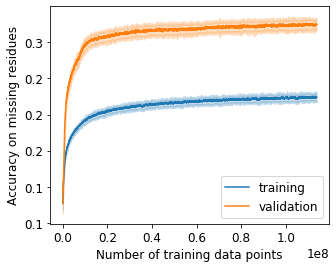

In [23]:
cmap = cm.get_cmap("tab10")

x = df["datapoint"].values
accuracy_m_mean, accuracy_m_std = df["accuracy_m"].ewm(com=16, min_periods=0).agg(['mean', 'std']).values.T
accuracy_mv_mean, accuracy_mv_std = df["accuracy_mv"].ewm(com=16, min_periods=0).agg(['mean', 'std']).values.T

# accuracy_m_std = np.nan_to_num(accuracy_m_std, 0)
# accuracy_mv_std = np.nan_to_num(accuracy_mv_std, 0)

fg, ax = plt.subplots(figsize=(5, 4))

ax.plot(x, accuracy_m_mean, label="training", color=cmap(0))
ax.fill_between(x, accuracy_m_mean - accuracy_m_std * 2, accuracy_m_mean + accuracy_m_std * 2, alpha=0.25, color=cmap(0))
ax.plot(x, accuracy_mv_mean, label="validation", color=cmap(1))
ax.fill_between(x, accuracy_mv_mean - accuracy_mv_std * 2, accuracy_mv_mean + accuracy_mv_std * 2, alpha=0.25, color=cmap(1))

# ax.hlines(0.7, 0, df["datapoint"].max(), linestyle='--')
ax.legend(loc="lower right")
ax.set_xlabel("Number of training data points")
ax.set_ylabel("Accuracy on missing residues")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# ax.set_ylim(0, 0.82)
# fg.savefig(NOTEBOOK_PATH / f"{UNIQUE_ID}-training-curve.svg", bbox_inches="tight")

## Test set sequence identity

### Oneshot

In [28]:
results = []
for i, data in enumerate(
    tqdm.tqdm_notebook(
        DataLoader(datasets["protein_test"], shuffle=False, num_workers=1, batch_size=1, drop_last=False)
    )
):
    data = data.to(device)
    data.y = data.x
    x_in = torch.ones_like(data.y) * 20
    is_missing = torch.ones(data.y.size(0), dtype=torch.bool)
    output = net(x_in, data.edge_index, data.edge_attr)
    output = torch.softmax(output, dim=1)
    _, predicted = output.max(dim=1)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append({"fraction_correct": num_correct / num_total, "num_correct": num_correct, "num_total": num_total})
oneshot_results_df = pd.DataFrame(results)

/home/strokach/env/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [29]:
fraction_correct_oneshot = (oneshot_results_df["num_correct"] / oneshot_results_df["num_total"]).mean()
fraction_correct_oneshot

0.2728685383656129

### Incremental

In [30]:
@torch.no_grad()
def design_protein(net, x, edge_index, edge_attr):
    mask = (x == 20)
    if not mask.any():
        return x
    output = net(x, edge_index, edge_attr)
    output = torch.softmax(output, dim=1)
    max_pred, max_index = output.max(dim=1)
    max_pred[~mask] = -1
    _, max_residue = max_pred.max(dim=0)
    x[max_residue] = max_index[max_residue]
    return design_protein(net, x, edge_index, edge_attr)

In [31]:
test_sequence_identity = {}

In [ ]:
for frac_present in [0.0, 0.5, 0.8]:
    results = []
    for i, data in enumerate(
        tqdm.tqdm_notebook(
            DataLoader(datasets["protein_test"], shuffle=False, num_workers=1, batch_size=1, drop_last=False)
        )
    ):
        data.to(device)
        if frac_present == 0:
            is_present = torch.zeros(data.x.size(0), dtype=torch.bool, device=data.x.device)
            x_in = torch.ones_like(data.x) * 20
        else:
            is_present = torch.rand(data.x.size(0), device=data.x.device) < frac_present
            x_in = torch.where(is_present, data.x, torch.tensor(20, device=data.x.device))
        x_pred = design_protein(net, x_in, data.edge_index, data.edge_attr)
        identity_all = float((x_pred == data.x).sum()) / data.x.size(0)
        identity_missing = float((x_pred[~is_present] == data.x[~is_present]).sum()) / (~is_present).sum().item()
        result = {
            "identity_all": identity_all,
            "identity_missing": identity_missing,
            "num_correct": (x_pred[~is_present] == data.x[~is_present]).sum().item(),
            "num_total": (~is_present).sum().item(),
        }
        results.append(result)
    test_sequence_identity[frac_present] = pd.DataFrame(results)

In [ ]:
fraction_correct_incremental = (test_sequence_identity[0.0]["num_correct"] / test_sequence_identity[0.0]["num_total"]).mean()
fraction_correct_incremental

In [ ]:
xlim = -0.025, 0.625

fg, ax = plt.subplots(figsize=(5, 4))
for frac, df in sorted(test_sequence_identity.items()):
    data = df["identity_missing"]
    data = np.clip(data, *xlim)
#         ax.hist(data, bins=30, range=xlim, histtype="step", label=f"{frac:.0%} missing residues", linewidth=1.5)
    sns.kdeplot(data, gridsize=35, label=f"{frac:.0%} residues present")
ax.set_ylabel("Number of sequences (normalized)")
ax.set_xlabel("Sequence identity to reference")
ax.set_xlim(*xlim)
# ax.set_ylim(0, 4.2)
ax.legend(loc="upper left", framealpha=0.3)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(f"{UNIQUE_ID}-test-incremental-kde.svg"), bbox_inches="tight")

In [ ]:
fg, ax = plt.subplots(figsize=(5, 4))

xlim = -0.025, 0.625

data = oneshot_results_df["fraction_correct"]
data = np.clip(data, *xlim)
ax.hist(
    data,
    bins=100,
    range=xlim,
    alpha=0.9,
    label=f"oneshot (accuracy: {fraction_correct_oneshot:.2%})",
    histtype="stepfilled",
    linewidth=2,
    color=cm.get_cmap("Set1")(1),
)
# sns.kdeplot(data, gridsize=200, label="oneshot")

data = test_sequence_identity[0.0]["identity_missing"]
data = np.clip(data, *xlim)
ax.hist(
    data,
    bins=100,
    range=xlim,
    alpha=0.6,
    label=f"incremental (accuracy: {fraction_correct_incremental:.2%})",
    histtype="stepfilled",
    linewidth=2,
    color=cm.get_cmap("Set1")(0),
)
# sns.kdeplot(data, gridsize=100, label="incremental")

ax.set_ylabel("Number of sequences")
ax.set_xlabel("Sequence identity to reference")
ax.set_xlim(xlim)
# ax.set_ylim(0, 165)

ax.legend(framealpha=0.5)

fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(f"{UNIQUE_ID}-test-oneshot-incremental.svg"), bbox_inches="tight")

## Protherm validation

In [24]:
results = []

for i, data in enumerate(tqdm.tqdm_notebook(protherm_dataset, total=len(protherm_dataset))):
    data = data.to(device)

    row = protherm_df.loc[data.Index.item()]
    with torch.no_grad():
        output = net(data.x, data.edge_index, data.edge_attr)

    wt_idx = torch.tensor(proteinsolver.utils.seq_to_tensor(row.mutation[0].encode()), dtype=torch.long, device=device)
    mut_idx = torch.tensor(
        proteinsolver.utils.seq_to_tensor(row.mutation[-1].encode()), dtype=torch.long, device=device
    )
    pos = int(row.mutation[1:-1])
    x_mut = data.x.clone()
    assert x_mut[pos - 1] == wt_idx
    x_mut[pos - 1] = mut_idx
    with torch.no_grad():
        output_mut = net(x_mut, data.edge_index, data.edge_attr)

    x_blank = data.x.clone()
    assert x_blank[pos - 1] == wt_idx
    x_blank[pos - 1] = 20
    with torch.no_grad():
        output_blank = net(x_blank, data.edge_index, data.edge_attr)

    # logproba.scan
    scan_wt = proteinsolver.utils.scan_with_mask(net, data.x, data.edge_index, data.edge_attr)
    scan_sm_wt = proteinsolver.utils.scan_with_mask(
        net, data.x, data.edge_index, data.edge_attr, output_transform="proba"
    )
    scan_sm_log_wt = proteinsolver.utils.scan_with_mask(
        net, data.x, data.edge_index, data.edge_attr, output_transform="logproba"
    )
    scan_mut = proteinsolver.utils.scan_with_mask(net, x_mut, data.edge_index, data.edge_attr)
    scan_sm_mut = proteinsolver.utils.scan_with_mask(
        net, x_mut, data.edge_index, data.edge_attr, output_transform="proba"
    )
    scan_sm_log_mut = proteinsolver.utils.scan_with_mask(
        net, x_mut, data.edge_index, data.edge_attr, output_transform="logproba"
    )

    # logproba.incremental
    incremental_wt = proteinsolver.utils.get_node_outputs(net, data.x, data.edge_index, data.edge_attr)
    incremental_sm_wt = proteinsolver.utils.get_node_outputs(
        net, data.x, data.edge_index, data.edge_attr, output_transform="proba"
    )
    incremental_sm_log_wt = proteinsolver.utils.get_node_outputs(
        net, data.x, data.edge_index, data.edge_attr, output_transform="logproba"
    )
    incremental_mut = proteinsolver.utils.get_node_outputs(net, x_mut, data.edge_index, data.edge_attr)
    incremental_sm_mut = proteinsolver.utils.get_node_outputs(
        net, x_mut, data.edge_index, data.edge_attr, output_transform="proba"
    )
    incremental_sm_log_mut = proteinsolver.utils.get_node_outputs(
        net, x_mut, data.edge_index, data.edge_attr, output_transform="logproba"
    )

    result = {
        "wt_wt": output[pos - 1, wt_idx].item(),
        "wt_mut": output[pos - 1, mut_idx].item(),
        "wt_sm_wt": torch.softmax(output, dim=1)[pos - 1, wt_idx].item(),
        "wt_sm_mut": torch.softmax(output, dim=1)[pos - 1, mut_idx].item(),
        "wt_sm_log_wt": torch.softmax(output, dim=1).log()[pos - 1, wt_idx].item(),
        "wt_sm_log_mut": torch.softmax(output, dim=1).log()[pos - 1, mut_idx].item(),
        #
        "mut_wt": output_mut[pos - 1, wt_idx].item(),
        "mut_mut": output_mut[pos - 1, mut_idx].item(),
        "mut_sm_wt": torch.softmax(output_mut, dim=1)[pos - 1, wt_idx].item(),
        "mut_sm_mut": torch.softmax(output_mut, dim=1)[pos - 1, mut_idx].item(),
        "mut_sm_log_wt": torch.softmax(output_mut, dim=1).log()[pos - 1, wt_idx].item(),
        "mut_sm_log_mut": torch.softmax(output_mut, dim=1).log()[pos - 1, mut_idx].item(),
        #
        "blank_wt": output_blank[pos - 1, wt_idx].item(),
        "blank_mut": output_blank[pos - 1, mut_idx].item(),
        "blank_sm_wt": torch.softmax(output_blank, dim=1)[pos - 1, wt_idx].item(),
        "blank_sm_mut": torch.softmax(output_blank, dim=1)[pos - 1, mut_idx].item(),
        "blank_sm_log_wt": torch.softmax(output_blank, dim=1).log()[pos - 1, wt_idx].item(),
        "blank_sm_log_mut": torch.softmax(output_blank, dim=1).log()[pos - 1, mut_idx].item(),
        #
        "scan_wt": scan_wt.mean().item(),
        "scan_mut": scan_mut.mean().item(),
        "scan_sm_wt": scan_sm_wt.mean().item(),
        "scan_sm_mut": scan_sm_mut.mean().item(),
        "scan_sm_log_wt": scan_sm_log_wt.mean().item(),
        "scan_sm_log_mut": scan_sm_log_mut.mean().item(),
        #
        "incremental_wt": incremental_wt.mean().item(),
        "incremental_mut": incremental_mut.mean().item(),
        "incremental_sm_wt": incremental_sm_wt.mean().item(),
        "incremental_sm_mut": incremental_sm_mut.mean().item(),
        "incremental_sm_log_wt": incremental_sm_log_wt.mean().item(),
        "incremental_sm_log_mut": incremental_sm_log_mut.mean().item(),
        #
        "ddg_exp": row.ddg_exp,
    }
    results.append(result)

results_df = pd.DataFrame(results)

In [33]:
# torch.save(results_df, NOTEBOOK_PATH.joinpath("protherm_results.torch"))

In [25]:
results_df = torch.load(NOTEBOOK_PATH.joinpath("protherm_results.torch"))

In [26]:
assert len(results_df) == len(results_df_bak)

In [27]:
assert (results_df.index == results_df_bak.index).all()

In [28]:
results_df["scan_sm_log_wt"] = results_df_bak["scan_sm_log_wt"]
results_df["scan_sm_log_mut"] = results_df_bak["scan_sm_log_mut"]

In [29]:
results_df["blank_change"] = results_df["blank_mut"] - results_df["blank_wt"]
results_df["blank_sm_change"] = results_df["blank_sm_mut"] - results_df["blank_sm_wt"]

results_df["wt_mut_change"] = results_df["mut_mut"] - results_df["wt_wt"]
results_df["wt_mut_sm_change"] = results_df["mut_sm_mut"] - results_df["wt_sm_wt"]

for prefix in ["scan", "scan_sm", "scan_sm_log", "incremental", "incremental_sm", "incremental_sm_log"]:
    results_df[f"{prefix}_change"] = results_df[f"{prefix}_mut"] - results_df[f"{prefix}_wt"]

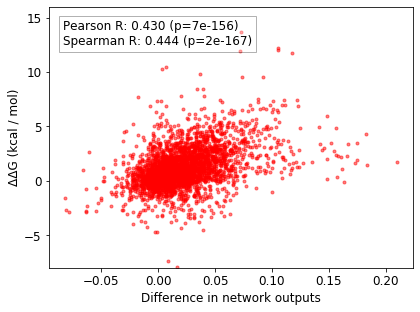

In [32]:
column = "scan_sm_log_change"

ddg_change = results_df[column].values
ddg_exp = results_df["ddg_exp"].values
textstr = """\
Pearson R: {:.3f} (p={:.0e})
Spearman R: {:.3f} (p={:.0e})
""".format(
    *stats.pearsonr(-ddg_change, ddg_exp), *stats.spearmanr(-ddg_change, ddg_exp)
).strip()
props = dict(facecolor="white", alpha=0.3)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4.5))
    ax.plot(-ddg_change, ddg_exp, "r.", alpha=0.5)
    ax.set_xlabel("Difference in network outputs")
    ax.set_ylabel("ΔΔG (kcal / mol)")
#     ax.set_xlim(-8, 16)
    ax.set_ylim(-8, 16)
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.tight_layout()
# fg.savefig(NOTEBOOK_PATH.joinpath(f"{UNIQUE_ID}-protherm-all.svg"), bbox_inches="tight")

## Timing

In [25]:
def design_sequences(structure, num_sequences):
    chain_id = next(structure.chains).id
    pdata = proteinsolver.utils.extract_seq_and_adj(structure, chain_id)
    data = proteinsolver.datasets.protein.row_to_data(pdata)
    data = proteinsolver.datasets.protein.transform_edge_attr(data)
    data.x = torch.ones_like(data.x) * 20
    data = data.to(device)
    for _ in range(num_sequences):
        _ = proteinsolver.utils.design_sequence(net, data)

In [26]:
structure_path = Path(proteinsolver.__path__[0]).joinpath("data", "inputs").resolve(strict=True)
for structure_id in ["5VLI", "1N5U", "4Z8J", "4UNU", "4BEU"]:
    structure_files = list(structure_path.glob(f"{structure_id.lower()}*.pdb"))
    assert len(structure_files) == 1, structure_files
    structure_file = structure_files[0]
    structure = PDB.load(structure_file)
    for num_designs in [1, 1000]:
        print(structure_file.name, num_designs)
        %time design_sequences(structure, num_designs)
        print()

5vli02.pdb 1
CPU times: user 165 ms, sys: 4.02 ms, total: 169 ms
Wall time: 168 ms

5vli02.pdb 1000
CPU times: user 1min 36s, sys: 422 ms, total: 1min 36s
Wall time: 1min 36s

1n5uA03.pdb 1
CPU times: user 393 ms, sys: 8.02 ms, total: 401 ms
Wall time: 400 ms

1n5uA03.pdb 1000
CPU times: user 3min 47s, sys: 1.1 s, total: 3min 48s
Wall time: 3min 48s

4z8jA00.pdb 1
CPU times: user 1.02 s, sys: 24 ms, total: 1.04 s
Wall time: 1.04 s

4z8jA00.pdb 1000
CPU times: user 3min 57s, sys: 1.28 s, total: 3min 59s
Wall time: 3min 59s

4unuA00.pdb 1
CPU times: user 556 ms, sys: 0 ns, total: 556 ms
Wall time: 555 ms

4unuA00.pdb 1000
CPU times: user 4min 29s, sys: 1.38 s, total: 4min 31s
Wall time: 4min 31s

4beuA02.pdb 1
CPU times: user 2.42 s, sys: 100 ms, total: 2.52 s
Wall time: 2.52 s

4beuA02.pdb 1000
CPU times: user 12min 36s, sys: 1min 12s, total: 13min 48s
Wall time: 13min 48s



## Perplexities

In [39]:
def calculate_perplexity(net, x, edge_index, edge_attr, x_in=None):
    if x_in is None:
        x_in = torch.ones_like(x) * 20

    mask = x_in == 20

    if not mask.any().item():
        return []

    output = net(x_in, edge_index, edge_attr)
    output = torch.softmax(output, dim=1)

    probas = output.gather(1, x.view(-1, 1))
    probas[~mask] = -1

    max_proba, max_residue = probas.max(dim=0)
    x_in[max_residue] = x[max_residue]

    return [max_proba.item()] + calculate_perplexity(net, x, edge_index, edge_attr, x_in=x_in)

In [40]:
proba_lists = []
for i, data in enumerate(
    tqdm.tqdm_notebook(
        DataLoader(datasets["protein_test"], shuffle=False, num_workers=1, batch_size=1, drop_last=False)
    )
):
    data = data.to(device)
    with torch.no_grad():
        proba_lst = calculate_perplexity(net, data.x, data.edge_index, data.edge_attr)
    assert len(proba_lst) == data.x.size(0)
    proba_lists.append(proba_lst)

/tmp/strokach/env/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [41]:
perplexities = [2 ** -(np.log2(proba_lst).mean()) for proba_lst in proba_lists]
print(np.mean(perplexities))

8.974993654617126


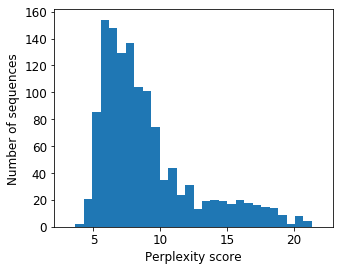

In [42]:
fg, ax = plt.subplots(figsize=(5, 4))
ax.hist(np.clip(perplexities, 3, 22), bins=30, range=(3, 22))
ax.set_xlabel("Perplexity score")
ax.set_ylabel("Number of sequences")
fg.savefig(NOTEBOOK_PATH.joinpath(f"{UNIQUE_ID}-perplexity.svg"), bbox_inches="tight")

In [43]:
raise Exception("Done!")

Exception: Done!

In [ ]:
results = []

for i, data in enumerate(tqdm.tqdm_notebook(protherm_dataset, total=len(protherm_dataset))):
    row = protherm_df.loc[data.Index.item()]
    data = data.to(device)

    with torch.no_grad():
        log_prob_wt = proteinsolver.utils.get_node_proba(net, data.x, data.edge_index, data.edge_attr, 20)

    wt_idx = torch.tensor(proteinsolver.utils.seq_to_tensor(row.mutation[0].encode()), dtype=torch.long, device=device)
    mut_idx = torch.tensor(proteinsolver.utils.seq_to_tensor(row.mutation[-1].encode()), dtype=torch.long, device=device)
    pos = int(row.mutation[1:-1])
    x_mut = data.x.clone()
    assert x_mut[pos - 1] == wt_idx
    x_mut[pos - 1] = mut_idx
    with torch.no_grad():
        log_prob_mut = proteinsolver.utils.get_node_proba(net, x_mut, data.edge_index, data.edge_attr, 20)
        
    results.append(log_prob_mut.sum().item() - log_prob_wt.sum().item())
        
results_df["sum_log_prob_change"] = results

In [ ]:
column = "sum_log_prob_change"
ddg_change = results_df[column].values
ddg_exp = results_df["ddg_exp"].values
textstr = """\
Pearson R: {:.3f} (p={:.0e})
Spearman R: {:.3f} (p={:.0e})
""".format(
    *stats.pearsonr(-ddg_change, ddg_exp), *stats.spearmanr(-ddg_change, ddg_exp)
).strip()
props = dict(facecolor="white", alpha=0.3)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4.5))
    ax.plot(-ddg_change, ddg_exp, "r.", alpha=0.5)
    ax.set_xlabel("Difference in network outputs")
    ax.set_ylabel("ΔΔG (kcal / mol)")
    ax.set_xlim(-8, 16)
    ax.set_ylim(-8, 16)
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.tight_layout()
# fg.savefig(NOTEBOOK_PATH.joinpath("protherm-all.svg"))

In [ ]:
# table = pa.Table.from_pandas(results_df)
# pq.write_table(table, NOTEBOOK_PATH.joinpath("results.parquet"))